In [ ]:
# Ваш импорт

In [ ]:
# Можно написать свои функции, либо переписать
def calculate_optimal_distance(list_clusters, list_score):
    """
    Поиск наибольшего расстояния для метода локтя
    """
    x1, y1 = list_clusters[0], list_score[0]
    x2, y2 = list_clusters[-1], list_score[-1]
    A, B, C = y1 - y2, x2 - x1, x1 * y2 - x2 * y1

    max_dist = -np.inf
    max_x = -np.inf
    for num, i in enumerate(list_score[1:-1]):
        x_0, y_0 = list_clusters[1:-1][num], list_score[1:-1][num]
        dist = abs(A * x_0 + B * y_0 + C) / np.sqrt(A**2 + B**2)

        if dist > max_dist:
            max_dist = dist
            max_x = x_0
        else:
            continue
    return max_dist, max_x


def elbow_picture(labels_std: list,
                  labels_min: list,
                  labels_max: list,
                  labels_median: list,
                  type_optimal: list,
                  min_size: int,
                  max_size: int):
    """
    Метод локтя

    Функция для вывода графика зависимостей стандартной ошибки, 
    минимального и максимального числа объектов от кол-ва кластеров
    """

    _, opt_cluster = calculate_optimal_distance(
        range(min_size, max_size + 1), type_optimal)

    plt.figure(figsize=(8, 6))
    plt.plot(range(min_size, max_size + 1), labels_std,
             marker='s', color='green', label='std')
    plt.plot(range(min_size, max_size + 1), labels_min,
             marker='s', color='grey', linestyle='dashed', label='min')
    plt.plot(range(min_size, max_size + 1), labels_median,
             marker='o', color='skyblue', linestyle='dashed', label='median')
    plt.plot(range(min_size, max_size + 1), labels_max,
             marker='o', color='grey',  linestyle='dashed', label='max')
    plt.xlabel('Кластер')
    plt.ylabel('Станд.ошибка / Мин.кластер / Median / Макс.кластер')
    plt.axvline(x=opt_cluster, color='black',
                label=f'optimal clust= {opt_cluster}', linestyle='dashed')
    plt.legend()
    plt.show();


def silhouette_plot(data: pd.DataFrame, labels: pd.Series, metrics='euclidean', ax=None):
    """
    Функция вывода графика силуэтного скора
    """
    if ax is None:
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(7, 5)
        
    silhouette_vals = silhouette_samples(data, labels, metric=metrics)

    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals,
                 edgecolor='none', height=1)
        ax.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Получение средней оценки силуэтного скора и построение графика
    avg_score = np.mean(silhouette_vals)
    ax.axvline(avg_score, linestyle='--', linewidth=1, color='red')
    ax.set_xlabel(f'Silhouette  = {round(avg_score,1)}')
    ax.set_ylabel('Метки кластеров')
    ax.set_title('График силуэта для различных кластеров', y=1.02)


def metric_picture(score_list: float, min_size: int, max_size: int,
                   name_metric, optimal: bool = True):
    """
    Функция для вывода графика зависимости силуэтной оценки от кол-ва кластеров
    """
    plt.figure(figsize=(8, 6))
    if optimal:
        _, opt_cluster = calculate_optimal_distance(
            range(min_size, max_size + 1), list_score=score_list)
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.axvline(x=opt_cluster, color='black',
                    label=f'optimal clust= {opt_cluster}', linestyle='dashed')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    else:
        plt.plot(range(min_size, max_size + 1), score_list, marker='s')
        plt.xlabel('$Clusters$')
        plt.ylabel(f'${name_metric}$')
    plt.show()
    

def check_fullness(data, labels):
    """
    Функция для проверки медианной заполненности кластера
    Для бинаризованных данных
    """
    sums = []
    #Пробегаем по кластерам
    for label in np.unique(labels):
        #Находим медианную заполненность кластера
        cluster_quantile = data[labels == label].sum(axis = 0).quantile(.5)
        sums.append(cluster_quantile)
    pd.DataFrame(sums).sort_values(by = [0]).plot(kind = "barh", figsize = (8, 6))
    plt.title('Заполненность кластеров')
    plt.ylabel('clusters')
    plt.show()
    

def plot_size(data: pd.DataFrame, labels: pd.Series):
    """
    Фунция для вывода графика размера кластеров    
    """
    plt.title('Размер кластеров')
    cluster_size = data.assign(cluster=labels).groupby(
        'cluster').count().iloc[:, 0]
    cluster_size.sort_values().plot.barh(figsize=(6, 4), color='C0')
    plt.show()
    
    
def plot_top_features(data, labels, n_clusters):
    """
    ТОП-признаки для бинаризованных данных
    """
    binary_label = data.assign(cluster = labels)
    size_cluster = binary_label.groupby('cluster').count().iloc[:,0]
    data_sum = binary_label.groupby('cluster').sum()
    data_sum_norm = data_sum.T / size_cluster

    fig, ax_lst = plt.subplots(n_clusters, 1, figsize = (6,n_clusters*5))
    plt.subplots_adjust(wspace=0.8, hspace=0.3)
    for i in range(n_clusters):
        ax_lst.reshape(-1)[i].set_title('cluster = ' + str(i));
        data_sum_norm.loc[:,i].sort_values()[-10:].plot.barh(ax=ax_lst.reshape(-1)[i], color='C0');
    plt.show();

# Кластеризация

1) Импортировать из папки Cookies датасеты:

- binary_80015360_10sample - датасет с куками (по интекса) и по id интересам (по столбца)
- taxonomy_aidata - таксономия (справочник, сопоставление id с интересами разного уровня агрегации)
- geonames_with_district - справочник с геоданными, где city - id города, тот же id расположен в файле binary_80015360_10sample в колонке `city`

- Также зафиксируйте `random_state`: RAND=10

- **Выберите только данные по России** (`country == 'RU'`)

In [ ]:
df = # Ваш код
taxonomy = # Ваш код
taxonomy = # Ваш код

geo = # Ваш код

2) Посмотрите на каждый из датасетов и выведите их

In [ ]:
# Ваш код

3) Необходимо как в примере из лекции сопоставить **id интереса** из с названием **segment_name** (колонка) в taxonomy, выбираем только **Aidata level_0**!

- Мы должны получить не просто id, а название сегмента

- Будьте аккуратны, так как последний столбец в датасете с куками - это город!
- В конечном итоге у вас должен получиться датасет с сопосталенными названиями сегментов, а последние две колонки - это страна и город

- Учесть, что могут быть дубли для некоторых столбцов, поэтому **агрегируйте** такие столбцы в один, если в одном из них была 1ца, то в новом столбце в соответвующей строке должна быть тоже 1ца, если были везде 0, то 0. 

In [ ]:
# Ваш код

4) Наподобие как с сегментами, нужно каждому id города в получившемся датасете (после переименования столбцов при помощи taxonomy) сопоставить название региона из файла **geo** (колонка `auto_region`).

- Для этого создайте новый датасет, где соедините получившийся **датасет на предыдущем шаге** и **geo** по признаку **city** (LEFT JOIN), вы получите дополнительную колонку **auto_region**

- Будьте аккуратны, так как тип данных признака city в датасете из задания 3 - str, а тип данных в geo.city - int (нужно преобразовать тип данных int признака city в geo файле в тип str)

- Удалите лишние признаки **city, country** в получившемся новом датасете

In [ ]:
# Ваш код

5) 

- Бинаризуйте новый признак auto_region (get_dummies), остальные признаки оставьте в том же виде, данные запишите в новый датасет
- Удалите признак **'auto_region_-'**
- У вас должно получиться 886 столбцов
- Ничего страшного, если пропали индексы кук, для обучения они нам не нужны

In [ ]:
# Ваш код

6) Возьмите пример из лекции, где мы отсекали плохозаполненные куки и сделайте отсечение данных по получившемуся порогу. Запишите результаты в новый датасет cleaned_dataset. Сэмпл брать не нужно!

Код начинался с:

```python
# Суммируем значения сегментов по кукам 
id_sums = df_label.sum(axis = 1)
```

In [ ]:
# Ваш код

Чтобы алгоритм спектарльной кластеризации считался быстрее, **возьмите сэмпл данных размером 15000** и запишите в переменную `df_sample`. **Только для спектральной!**

In [ ]:
# Ваш код

## UMAP

7) 

- Примените метод UMAP для датасета `cleaned_dataset` и для `df_sample` отдельно, создайте эмбеддинги с параметрами `n_components=2` (двумерное пространство), не забывайте про random_state
- Отобразите как в примере из лекций эмбеддинги на двумерном графике

In [ ]:
# Ваш код

## Clustering

### SpectralClustering

8) Выбор кол-ва кластеров на основании спектральной кластеризации

- 1) создайте пустые списки для: 
    - значения стандартной ошибки, min, median и max кол-ва объектов в кластере
    - метрики calinski_harabasz
    - silhouette
- 2) В цикле вам необходимо от 2 до 10 кластеров сделать следующие действия:
    - 2.1) обучить алгоритм спектральной кластеризации на кол-ве кластеров на текущем шаге цикла, использовать `df_sample`, а также `affinity='cosine'`
    - 2.2) вывести график топ фичей при помощи функции `plot_top_features()`, подав на вход датасет `df_sample`, размеченные метки кластеров (пример `clf.labels_`) а также кол-во кластеров на текущем шаге цикла
    - 2.3) вывести график силуэтного скора при помощи функции `silhouette_plot()`, подав на вход датасет df_sample, размеченные метки кластеров (пример `clf.labels_`), а также **косинусную метрику**
    - 2.4) вывести график заполенности при помощи функции `check_fullness()`, подав на вход датасет `df_sample`, размеченные метки кластеров (пример `clf.labels_`)
    - 2.5) вывести график размеров кластеров при помощи функции `plot_size()`, подав на вход датасет `df_sample`, размеченные метки кластеров (пример `clf.labels_`)
    - 2.6) Добавить в списки для calinski_harabasz, silhouette соответствующие значения метрик, для silhouette использовать **косинусную метрику при вычислении значения**
    - 2.7) как в примере из лекций вычислить кол-во уникальных объектов в каждом кластере (`_, counts = np.unique(clf.labels_, return_counts=True)`)
    - 2.8) найти стандартную ошибку, min, median и max кол-во объектов в кластере, используя предыдущий пункт, и записать в соответствующие ранее объявленные списки
- 3) после самого цикла вывести графики:
    - 3.1) зависимостей стандартной ошибки, min, median, max при помощи функции `elbow_picture()`, подав на вход списки, которые заполняли в цикле на шаге 2.7 
    - 3.2) Изменение метрики calinski_harabasz в зависимости от кол-ва кластеров, используя метод `metric_picture()`
    - 3.3) Изменение метрики silhouette в зависимости от кол-ва кластеров, используя метод `metric_picture()`
    
**Важно** везде используйте датасет из задания 6, даже для подачи в разные метрики

**P.S. считается долго, можно пойти пока попить кофе/чай =)**

In [ ]:
# Ваш код

9) **Выбор оптимального кол-ва кластеров и вывод графиков**:

- Выберите оптимальное кол-во кластеров (основывайтесь на разных метриках, в том числе и на интерпретации) и обучите алгоритм спектральной кластеризации на `df_sample` (применять цикл не нужно)
- Отобразите эмбеддинги для `df_sample` на двумерном графике, цветами обозначьте метки новых кластеров

In [ ]:
# Ваш код

10) **Интерпретация результатов**

- Обучите алгоритм классификации (тут стоит выбрать самим) на данных метках кластера и `df_sample`
- Получите на датасете `cleaned_dataset` метки кластеров при помощи обученного алгоритма классификации
- Создайте новый датасет `cleaned_dataset_spec` копию `cleaned_dataset`, добавьте столбец `target` - кластеры, полученные в прошлом пункте
- Посчитайте кол-во объектов в каждом кластере, запишите в переменную `count`
- Отнормируйте кол-во объектов в каждом из признаков в кластере на общее кол-во объектов в кластере - `count`, запишите в переменную `normalize_spec`
- Постройте heatmap для `normalize_spec` heatmap и **опишите каждый кластер**

**Шпаргалка по описанию кластеров**
    
    Как лучше описать кластеры:
    - по полу
    - по возрасту
    - интересам
    - семейное положение (мб есть дети)
    - локация
    - доход (как дополнительно)

In [ ]:
# Ваш код

### DBSCAN

11) Так как для DBSCAN нет необходимости задавать кол-во кластеров то:

- Обучите DBSCAN на `cleaned_dataset`
- Постройте графики при помощи функций `plot_top_features()`, `silhouette_plot()`, `check_fullness()`, `plot_size()`
- Обязательно подобрать подобрать параметр `eps`, в презентации была ссылка на пример с подбором

In [ ]:
# Ваш код

12) **Результат DBSCAN**

- Сколько кластеров вы получили? Похоже ли на тот результат, что выдала спектральная кластеризация
- Отобразите эмбеддинги на двумерном графике, цветами обозначьте метки новых кластеров

In [ ]:
# Ваш код

### KMeans

13) Выбор кол-ва кластеров на основании **KMeans**

- 1) создайте пустые списки для: 
    - значения стандартной ошибки, min, median и max кол-ва объектов в кластере
    - метрики calinski_harabasz
    - silhouette
- 2) В цикле вам необходимо от 2 до 10 кластеров сделать следующие действия:
    - 2.1) обучить алгоритм спектральной кластеризации на кол-ве кластеров на текущем шаге цикла, использовать `cleaned_dataset`
    - 2.2) вывести график топ фичей при помощи функции `plot_top_features()`, подав на вход `cleaned_dataset`, размеченные метки кластеров (пример `clf.labels_`) а также кол-во кластеров на текущем шаге цикла
    - 2.3) вывести график силуэтного скора при помощи функции `silhouette_plot()`, подав на вход cleaned_dataset, размеченные метки кластеров (пример `clf.labels_`)
    - 2.4) вывести график заполенности при помощи функции `check_fullness()`, подав на вход `cleaned_dataset`, размеченные метки кластеров (пример `clf.labels_`)
    - 2.5) вывести график размеров кластеров при помощи функции `plot_size()`, подав на вход `cleaned_dataset`, размеченные метки кластеров (пример `clf.labels_`)
    - 2.6) Добавить в списки для calinski_harabasz, silhouette соответствующие значения метрик, для silhouette использовать **косинусную метрику при вычислении значения**
    - 2.7) как в примере из лекций вычислить кол-во уникальных объектов в каждом кластере (`_, counts = np.unique(clf.labels_, return_counts=True)`)
    - 2.8) найти стандартную ошибку, min, median и max кол-во объектов в кластере, используя предыдущий пункт, и записать в соответствующие ранее объявленные списки
- 3) после самого цикла вывести графики:
    - 3.1) зависимостей стандартной ошибки + min + median + max при помощи функции `elbow_picture()`, подав на вход списки, которые заполняли в цикле на шаге 2.7 
    - 3.2) Изменение метрики calinski_harabasz в зависимости от кол-ва кластеров, используя метод `metric_picture()`
    - 3.3) Изменение метрики silhouette в зависимости от кол-ва кластеров, используя метод `metric_picture()`
    
**Важно** везде используйте датасет из задания 6, даже для подачи в разные метрики

**P.S. считается долго, можно пойти пока попить кофе/чай =)**

In [ ]:
# Ваш код

14) **Выбор оптимального кол-ва кластеров и вывод графиков:**

- Выберите оптимальное кол-во кластеров (основывайтесь на разных метриках, в том числе и на интерпретации) и обучите алгоритм Kmeans (применять цикл не нужно) на `cleaned_dataset`
- Отобразите эмбеддинги для `cleaned_dataset` на двумерном графике, цветами обозначьте метки новых кластеров

In [ ]:
# Ваш код

15) **Интерпретация результатов**

- Создайте новый датасет `cleaned_dataset_km` копию `cleaned_dataset`, добавьте столбец `target` - кластеры, полученные в задании 14
- Посчитайте кол-во объектов в каждом кластере, запишите в переменную `count`
- Отнормируйте кол-во объектов в каждом из признаков в кластере на общее кол-во объектов в кластере - count, запишите в переменную `normalize_km`
- Постройте heatmap для `normalize_km` и **опишите каждый кластер**


**Шпаргалка по описанию кластеров**
    
    Как лучше описать кластеры:
    - по полу
    - по возрасту
    - интересам
    - семейное положение (мб есть дети)
    - локация
    - доход (как дополнительно)

In [ ]:
# Ваш код

16) Сравните разные подходы кластеризации, выберите тот метод, которые лучше всего разделил на кластеры с учетом интерпретации

# * Задание со звездочкой

1) Создайте функцию/ии, которые бы отображали ТОП-N признаков по таким категориям в каждом из кластеров:
    
- Общие признаки, не включая сведения о доходах (Income), пол, возраст, расположение (auto region)
- Расположение (auto region)
- Пол
- Возраст

Можете расположить данные категории в одну строку, каждая строка характеризует какой-то кластер. Пример на картинке ниже

P.S. также при помощи данного задания вы можете оценить интерпретацию и других методов кластеризации

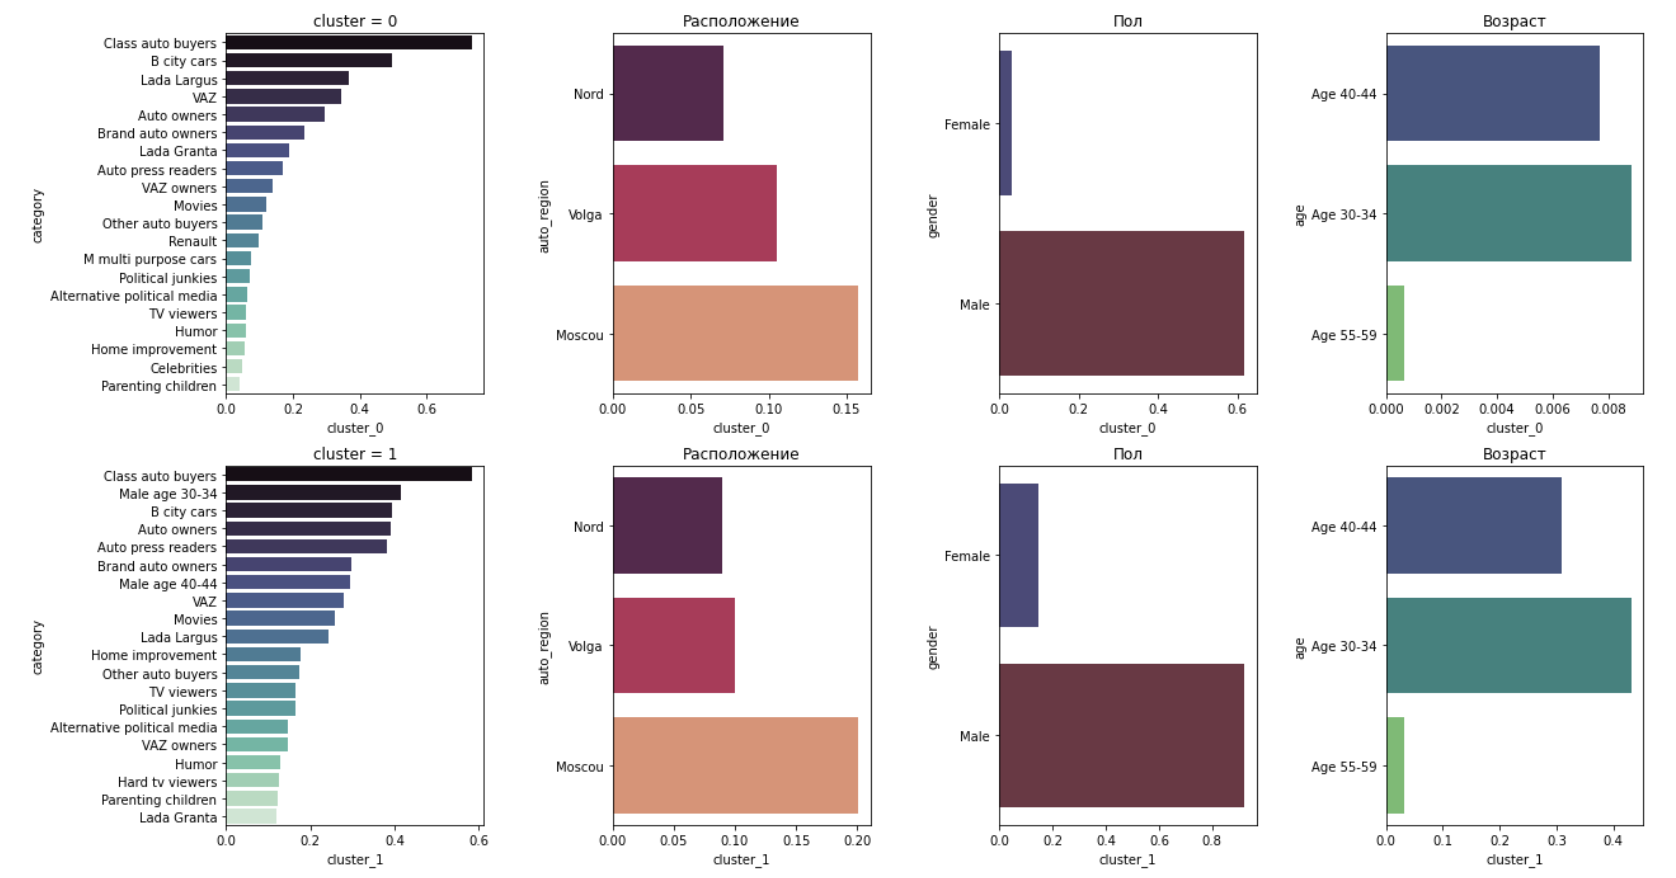

In [ ]:
# Ваш код

2) Примените написанную функцию для датасетов `cleaned_dataset_spec` и `cleaned_dataset_km`, сравните результаты

In [ ]:
# Ваш код